 # Regresión Logística con Características Temporales



 **Objetivo:** Entender la Regresión Logística de principio a fin, centrándonos en cómo manejar características temporales, cómo la regularización (L1 vs L2) afecta a nuestro modelo y cómo evaluar correctamente un problema de clasificación.



 **Dataset:** Usaremos un dataset *sintético* de e-commerce. Esto nos permite simular y controlar las propiedades de los datos para asegurarnos de que conceptos como la estacionalidad (hora del día, mes) y el ruido sean evidentes.



 **Escenario:** Queremos predecir si un usuario comprará (`purchased` = 1) o no (`purchased` = 0) basándonos en su comportamiento de sesión y cuándo ocurrió.



 **Estructura:**

 1.  Creación del Dataset

 2.  Feature Engineering (Codificación Cíclica y Features de Series Temporales)

 3.  Pipeline de Preprocesamiento y Split Cronológico

 4.  Conceptos Fundamentales: Odds y Odds Ratio

 5.  Interpretación Práctica de Coeficientes

 6.  Evaluación Completa del Modelo Base (L2)

 7.  Experimento 1: Regularización L1 (Lasso) vs. L2 (Ridge)

 8.  Experimento 2: Codificación Cíclica vs. Numérica Simple

 9.  Consejos e introducción a data leakage

In [21]:
# === Importaciones Principales ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# --- Preprocesamiento ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Modelo ---
from sklearn.linear_model import LogisticRegression

# --- Métricas ---
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_recall_fscore_support,
    roc_auc_score,
    f1_score
)

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Usaremos esta semilla en todas las operaciones aleatorias
# para asegurar que el notebook sea 100% reproducible.
SEED = 42


 ## 1. Creación del Dataset Sintético



 Creamos un dataset donde la probabilidad de compra depende de la hora, el día de la semana y otras características.

In [23]:
def crear_dataset_ecommerce(n_samples=3000, n_users=500, seed=42):
    """
    Crea un dataset sintético de e-commerce con características temporales,
    IDs de usuario y una semilla para reproducibilidad.
    """

    # Esto es mejor que np.random.seed() porque no afecta el estado global.
    rng = np.random.default_rng(seed)

    # 1. Tiempos (creados en orden cronológico)
    end_time = datetime.now()
    start_time = end_time - timedelta(days=365)
    raw_times = [start_time + (end_time - start_time) * rng.random() for _ in range(n_samples)]
    timestamps = sorted(raw_times) # Aseguramos el orden cronológico

    # 2. Características base
    df = pd.DataFrame({'timestamp': timestamps})
    # Usamos rng.choice(), rng.lognormal(), rng.poisson()
    df['user_id'] = rng.choice(range(1, n_users + 1), size=n_samples) # Asignar IDs de usuario
    df['session_duration_sec'] = rng.lognormal(mean=4.5, sigma=0.8, size=n_samples).astype(int)
    df['page_views'] = rng.poisson(lam=5, size=n_samples) + 1
    df['device_type'] = rng.choice(['mobile', 'desktop', 'tablet'], size=n_samples, p=[0.5, 0.4, 0.1])

    # 3. Características para regularización
    # Usamos rng.normal(), rng.integers()
    df['avg_time_on_page'] = df['page_views'] * rng.normal(1.5, 0.2, size=n_samples) # Correlacionada
    df['campaign_id'] = rng.integers(1, 20, size=n_samples)

    # 4. Generar el objetivo (Log-Odds)
    log_odds = -2.0  # Intercepto (probabilidad base baja)

    # Efecto de la hora (pico por la noche, ~8 PM)
    hour_effect = -np.cos(2 * np.pi * df['timestamp'].dt.hour / 24) * 1.5
    log_odds += hour_effect

    # Efecto del día de la semana (pico en fin de semana)
    day_effect = (df['timestamp'].dt.dayofweek.isin([5, 6])) * 0.7 # Extra boost Sábado/Domingo
    log_odds += day_effect

    # Efectos de otras features
    log_odds += df['page_views'] * 0.25
    log_odds += (df['device_type'] == 'desktop') * 0.5
    log_odds -= (df['device_type'] == 'mobile') * 0.3

    # Convertir Log-Odds a Probabilidad (Función Sigmoide)
    prob = 1 / (1 + np.exp(-log_odds))

    # Generar objetivo binario (Usamos rng.random())
    df['purchased'] = (rng.random(n_samples) < prob).astype(int)

    print(f"Dataset creado con {n_samples} muestras y {n_users} usuarios.")
    print(f"Intervalo de fechas: {df['timestamp'].min()} a {df['timestamp'].max()}")
    print(f"Tasa de conversión (clase 1): {df['purchased'].mean():.2%}")

    return df

In [24]:
df_original = crear_dataset_ecommerce(n_samples=3000, n_users=500, seed=SEED)

Dataset creado con 3000 muestras y 500 usuarios.
Intervalo de fechas: 2024-11-05 07:45:23.489113 a 2025-11-05 01:09:24.038034
Tasa de conversión (clase 1): 47.33%


In [25]:
df_original.head()

,timestamp,user_id,session_duration_sec,page_views,device_type,avg_time_on_page,campaign_id,purchased
0,2024-11-05 07:45:23.489113,310,94,5,mobile,6.420144,6,0
1,2024-11-05 08:11:20.897413,415,62,12,tablet,18.051746,7,1
2,2024-11-05 11:53:04.821566,321,39,10,desktop,14.346672,6,1
3,2024-11-05 12:33:47.950060,298,32,11,mobile,18.264124,9,1
4,2024-11-05 14:00:50.232479,234,86,4,tablet,6.651507,18,0


In [36]:
df_original.shape

(3000, 8)

 ## 2. Feature Engineering (Codificación Cíclica y Features de Series Temporales)



 Esta es la sección más importante. Crearemos dos tipos de features.



 ### 2.1. Codificación Cíclica



 **¿Por qué hacemos esto? (El problema del reloj)**



 Pensemos en la característica `hour_of_day`. Para un modelo de regresión, los valores `23` (11 PM) y `0` (12 AM) están numéricamente muy lejos. Sin embargo, en la realidad, están muy cerca: solo hay una hora de diferencia.



 El modelo no puede entender que "después de 23 viene 0". Para él, 0 está más cerca de 1 que de 23.



 **La Solución: Mapear a un Círculo**



 Al igual que en un reloj analógico, podemos representar la hora en un círculo. Hacemos esto usando las funciones trigonométricas Seno y Coseno.



 -   `hora_sin = sin( angulo_hora )`

 -   `hora_cos = cos( angulo_hora )`



 De esta forma, las 23:00 (ej. `sin=0.25, cos=0.96`) y las 00:00 (ej. `sin=0, cos=1`) tendrán valores `(sin, cos)` muy similares. El modelo ahora puede "ver" que estas horas están juntas.



 Haremos esto para `hour_of_day`, `day_of_week` y `month`.

In [26]:
def encode_cyclical(df, col, max_val):
    """
    Codifica una característica temporal cíclica usando Seno y Coseno.

    max_val: El valor máximo (p.ej. 24 para horas, 12 para meses).
    """
    # Calculamos el ángulo (normalizado a 2*pi, que es un círculo completo)
    angle = 2 * np.pi * df[col] / max_val
    df[col + '_sin'] = np.sin(angle)
    df[col + '_cos'] = np.cos(angle)
    return df

In [27]:
# Copiamos el dataframe para procesarlo
df_processed = df_original.copy()

# --- 1. Extracción Base ---
# Extraemos los componentes de tiempo que usaremos
df_processed['month'] = df_processed['timestamp'].dt.month
df_processed['day_of_week'] = df_processed['timestamp'].dt.dayofweek # Lunes=0, Domingo=6
df_processed['hour_of_day'] = df_processed['timestamp'].dt.hour

# --- 2. Codificación Cíclica ---
print("Aplicando codificación cíclica...")
df_processed = encode_cyclical(df_processed, 'month', 12)
df_processed = encode_cyclical(df_processed, 'day_of_week', 7)
df_processed = encode_cyclical(df_processed, 'hour_of_day', 24)

# --- 3. Variables Dummy (se harán en el pipeline) ---
df_processed['campaign_id'] = df_processed['campaign_id'].astype('category')

Aplicando codificación cíclica...


In [28]:
print("DataFrame después de la codificación cíclica:")
df_processed.head()

DataFrame después de la codificación cíclica:


,timestamp,user_id,session_duration_sec,page_views,device_type,avg_time_on_page,campaign_id,purchased,month,day_of_week,hour_of_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_of_day_sin,hour_of_day_cos
0,2024-11-05 07:45:23.489113,310,94,5,mobile,6.420144,6,0,11,1,7,-0.5,0.866025,0.781831,0.62349,9.659258e-01,-0.258819
1,2024-11-05 08:11:20.897413,415,62,12,tablet,18.051746,7,1,11,1,8,-0.5,0.866025,0.781831,0.62349,8.660254e-01,-0.500000
2,2024-11-05 11:53:04.821566,321,39,10,desktop,14.346672,6,1,11,1,11,-0.5,0.866025,0.781831,0.62349,2.588190e-01,-0.965926
3,2024-11-05 12:33:47.950060,298,32,11,mobile,18.264124,9,1,11,1,12,-0.5,0.866025,0.781831,0.62349,1.224647e-16,-1.000000
4,2024-11-05 14:00:50.232479,234,86,4,tablet,6.651507,18,0,11,1,14,-0.5,0.866025,0.781831,0.62349,-5.000000e-01,-0.866025


In [35]:
df_processed.shape

(3000, 21)

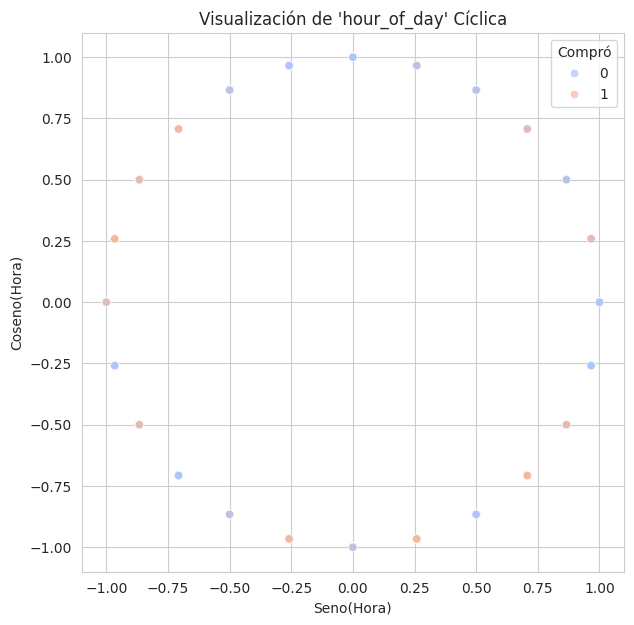

In [29]:
# Visualicemos la codificación cíclica de 'hour_of_day'
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_processed.rename(columns={'purchased': 'Compró'}),
                x='hour_of_day_sin',
                y='hour_of_day_cos',
                hue='Compró',
                palette='coolwarm',
                alpha=0.7)
plt.title("Visualización de 'hour_of_day' Cíclica")
plt.xlabel("Seno(Hora)")
plt.ylabel("Coseno(Hora)")
plt.legend(title='Compró', loc='upper right')
plt.show()


 **Interpretación del Gráfico:**



 El gráfico de arriba muestra nuestras 24 horas mapeadas a un círculo.



 -   La **Hora 0** (medianoche) está en la posición (sin=0, cos=1) - la parte superior del círculo.

 -   La **Hora 6** (6 AM) está en (sin=1, cos=0) - el extremo derecho.

 -   La **Hora 12** (mediodía) está en (sin=0, cos=-1) - la parte inferior.

 -   La **Hora 18** (6 PM) está en (sin=-1, cos=0) - el extremo izquierdo.



 Observa cómo las compras (puntos azules) se agrupan en una zona específica (probablemente la noche, entre las 18:00 y las 23:00). El modelo ahora puede identificar fácilmente este "cluster" circular.

 ### 2.2. Features de Series Temporales (Lags y Medias Móviles)



 Ahora, usamos el `user_id` para crear features que capturen el *comportamiento pasado* del usuario. Esto es extremadamente potente.



 **¡IMPORTANTE! Evitar Data Leakage (Fuga de Datos)**



 El error más grave en series temporales es usar información del futuro para predecir el presente. Para evitarlo, debemos asegurarnos de que nuestras features *solo* usen datos de sesiones *anteriores* a la actual.



 Haremos esto en 5 pasos:

 1.  **Ordenar por `user_id` y `timestamp`:** Agrupa todas las sesiones de un usuario, en orden.

 2.  **Usar `.shift(1)`:** Esta es la función clave. Desplaza los datos una fila hacia abajo. Así, la fila actual (sesión `N`) puede ver los datos de la sesión `N-1`.

 3.  **Calcular Features (Lags, Rolling, Expanding):**

     -   **Lags (`.shift(1)`):** ¿Qué pasó *exactamente* en la sesión anterior? (Ej. `lag_1_page_views`). Responde: "¿El comportamiento *inmediato* pasado importa?"

     -   **Rolling (`.shift(1).rolling(window=N)`):** ¿Cuál es la media de las `N` sesiones anteriores? (Ej. `rolling_avg_3_page_views`). Responde: "¿Cuál es la *tendencia reciente* del usuario?"

     -   **Expanding (`.shift(1).expanding()`):** ¿Cuál es la media de *toda la historia* del usuario (antes de esta sesión)? (Ej. `rolling_conversion_rate`). Responde: "¿Cuál es el *comportamiento histórico* del usuario?"

 4.  **Rellenar NaNs:** La primera sesión de un usuario no tiene pasado, por lo que `.shift(1)` creará un `NaN` (valor nulo). Debemos rellenarlo (ej. con 0).

 5.  **Re-ordenar por `timestamp`:** Volver al orden cronológico global para hacer el split de entrenamiento/prueba.

In [30]:
print(f"Ordenando por usuario y tiempo...")
# 1. Ordenar por usuario y tiempo (agrupa sesiones por usuario)
df_processed = df_processed.sort_values(['user_id', 'timestamp'])

# --- 2. Lag Features (Variables Retrasadas) ---

# ¿Cuánto tiempo pasó desde su última sesión?
# .diff() calcula la diferencia (delta) con la fila anterior (dentro del grupo)
df_processed['time_since_last_session_sec'] = df_processed.groupby('user_id')['timestamp'].diff().dt.total_seconds()

# ¿Cuántas page_views tuvo en su sesión anterior?
# .shift(1) mira el valor de la fila anterior (dentro del grupo)
df_processed['lag_1_page_views'] = df_processed.groupby('user_id')['page_views'].shift(1)


# --- 3. Rolling Features (Medias Móviles) ---

# ¿Cuál es el promedio de page_views en sus últimas 3 sesiones?
# ¡VITAL! Primero hacemos .shift(1) para excluir la sesión actual.
# Luego calculamos el .rolling() sobre las sesiones pasadas.
df_processed['rolling_avg_3_page_views'] = df_processed.groupby('user_id')['page_views'] \
                                           .shift(1) \
                                           .rolling(window=3, min_periods=1) \
                                           .mean()

# ¿Cuál es su tasa de conversión histórica (sin incluir esta sesión)?
# .expanding() calcula la media sobre *toda la historia* (creciente).
df_processed['rolling_conversion_rate'] = df_processed.groupby('user_id')['purchased'] \
                                            .shift(1) \
                                            .expanding(min_periods=1) \
                                            .mean()

# --- 4. Rellenar NaNs ---
print("Rellenando NaNs (primeras sesiones de cada usuario)...")
features_con_nans = ['time_since_last_session_sec', 'lag_1_page_views',
                     'rolling_avg_3_page_views', 'rolling_conversion_rate']
# Rellenamos con 0. Para 'time_since_last_session' esto significa
# que es su "primera sesión".
df_processed[features_con_nans] = df_processed[features_con_nans].fillna(0)

# --- 5. Re-ordenar por Timestamp ---
print("Re-ordenando por timestamp para el split cronológico...")
df_processed = df_processed.sort_values('timestamp')



Ordenando por usuario y tiempo...
Rellenando NaNs (primeras sesiones de cada usuario)...
Re-ordenando por timestamp para el split cronológico...


In [31]:
print("\nDataFrame final con todas las features:")
display(df_processed.head())


DataFrame final con todas las features:


,timestamp,user_id,session_duration_sec,page_views,device_type,avg_time_on_page,campaign_id,purchased,month,day_of_week,...,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_of_day_sin,hour_of_day_cos,time_since_last_session_sec,lag_1_page_views,rolling_avg_3_page_views,rolling_conversion_rate
0,2024-11-05 07:45:23.489113,310,94,5,mobile,6.420144,6,0,11,1,...,-0.5,0.866025,0.781831,0.62349,9.659258e-01,-0.258819,0.0,0.0,6.0,0.468966
1,2024-11-05 08:11:20.897413,415,62,12,tablet,18.051746,7,1,11,1,...,-0.5,0.866025,0.781831,0.62349,8.660254e-01,-0.500000,0.0,0.0,4.5,0.480132
2,2024-11-05 11:53:04.821566,321,39,10,desktop,14.346672,6,1,11,1,...,-0.5,0.866025,0.781831,0.62349,2.588190e-01,-0.965926,0.0,0.0,5.0,0.470696
3,2024-11-05 12:33:47.950060,298,32,11,mobile,18.264124,9,1,11,1,...,-0.5,0.866025,0.781831,0.62349,1.224647e-16,-1.000000,0.0,0.0,5.0,0.469628
4,2024-11-05 14:00:50.232479,234,86,4,tablet,6.651507,18,0,11,1,...,-0.5,0.866025,0.781831,0.62349,-5.000000e-01,-0.866025,0.0,0.0,9.5,0.464467


 ## 3. Pipeline de Preprocesamiento y Split Cronológico



 Ahora, preparamos el pipeline.



 **Split Cronológico (No Aleatorio)**



 Es fundamental. No podemos usar `train_test_split` de Scikit-Learn porque eso mezclaría los datos aleatoriamente. Estaríamos entrenando con datos del "futuro" para predecir el "pasado", causando *data leakage*.



 La forma correcta es usar el 80% más antiguo de los datos como `train` y el 20% más reciente como `test`.

In [32]:
# --- 1. Definir Características y Objetivo ---
TARGET = 'purchased'

# Características numéricas (para escalar)
NUMERIC_FEATURES = [
    'session_duration_sec', 'page_views', 'avg_time_on_page',
    'time_since_last_session_sec', 'lag_1_page_views',
    'rolling_avg_3_page_views', 'rolling_conversion_rate'
]

# Características cíclicas (ya están entre -1 y 1, pero las re-escalamos por buena práctica)
CYCLICAL_FEATURES = [
    'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    'hour_of_day_sin', 'hour_of_day_cos'
]

# Características categóricas (para One-Hot Encoding)
CATEGORICAL_FEATURES = ['device_type', 'campaign_id']

# Lista completa de features
# Excluimos 'user_id' y 'timestamp' originales del modelo
FEATURES = NUMERIC_FEATURES + CYCLICAL_FEATURES + CATEGORICAL_FEATURES

In [33]:
FEATURES

['session_duration_sec',
 'page_views',
 'avg_time_on_page',
 'time_since_last_session_sec',
 'lag_1_page_views',
 'rolling_avg_3_page_views',
 'rolling_conversion_rate',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'hour_of_day_sin',
 'hour_of_day_cos',
 'device_type',
 'campaign_id']

In [34]:
len(FEATURES)

15

In [37]:
# --- 2. Separar Datos (Split Cronológico) ---
# Usamos el df_processed, que ya está ordenado por 'timestamp'
X = df_processed[FEATURES]
y = df_processed[TARGET]

test_size_percent = 0.20
split_index = int(len(X) * (1 - test_size_percent))

print(f"Dividiendo en el índice: {split_index} (de {len(X)} muestras)")

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

Dividiendo en el índice: 2400 (de 3000 muestras)


In [38]:
# Verificamos las fechas para estar seguros
# (Usamos df_original solo para obtener las fechas correspondientes a los índices)
train_dates = df_original.iloc[:split_index]['timestamp']
test_dates = df_original.iloc[split_index:]['timestamp']

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}\n")
print(f"Fechas de Train: {train_dates.min()} a {train_dates.max()}")
print(f"Fechas de Test:  {test_dates.min()} a {test_dates.max()}")
print(f"\n¿Overlap de fechas? {'No' if train_dates.max() < test_dates.min() else 'SÍ, ERROR'}")

Forma de X_train: (2400, 15)
Forma de X_test: (600, 15)

Fechas de Train: 2024-11-05 07:45:23.489113 a 2025-08-24 21:15:21.815485
Fechas de Test:  2025-08-25 02:54:28.500240 a 2025-11-05 01:09:24.038034

¿Overlap de fechas? No


In [39]:
# --- 3. Crear el Pipeline de Preprocesamiento ---

# Pipeline para features numéricas y cíclicas
# Usamos StandardScaler para que todas tengan media 0 y desviación 1.
# Esto es crucial para la Regresión Logística y la regularización.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para features categóricas
# OneHotEncoder crea columnas dummy (0s y 1s) para cada categoría.
# handle_unknown='ignore': Si aparece una categoría nueva en test, la ignora.
# drop='first': Evita multicolinealidad (ej. para 'device_type' crea solo 2 columnas)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combinar preprocesadores usando ColumnTransformer
# Le dice al pipeline qué transformador aplicar a qué columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES + CYCLICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # Dejar pasar columnas no especificadas (si las hubiera)
)


In [40]:
# --- 4. Entrenamiento del Modelo Base (L2 - Ridge) ---
# Entrenamos nuestro modelo principal con L2 (Ridge), que es una buena
# regularización por defecto.
pipeline_l2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=1.0, # Nivel de regularización (inverso)
        solver='lbfgs',
        random_state=SEED,
        max_iter=1000
    ))
])

print("\nEntrenando Modelo Base L2 (Ridge) con split cronológico...")
pipeline_l2.fit(X_train, y_train)
print("Entrenamiento completado.")



Entrenando Modelo Base L2 (Ridge) con split cronológico...
Entrenamiento completado.


 ## 4. Conceptos Fundamentales: Odds y Odds Ratio



 Antes de interpretar o evaluar, repasemos qué calcula el modelo.



 ### Probabilidad (p)

 Es la métrica más intuitiva.

 -   `p = 0.8` (Hay un 80% de probabilidad de que llueva).

 -   Varía entre 0 y 1.



 ### Odds (Ventaja o "Momios" o "Chance")

 Es otra forma de expresar la probabilidad.

 `Odds = p / (1 - p)` (Probabilidad de que ocurra / Probabilidad de que NO ocurra)



 -   Si `p = 0.8` (80% lluvia), `Odds = 0.8 / (1 - 0.8) = 0.8 / 0.2 = 4`. (Odds 4 a 1).

 -   Si `p = 0.5` (50% lluvia), `Odds = 0.5 / 0.5 = 1`. (Odds "parejos").



 ### Log-Odds

 La Regresión Logística modela los **Log-Odds** (el logaritmo de los Odds) como una ecuación lineal:

 `log(p / (1-p)) = β₀ + β₁X₁ + β₂X₂ + ...`



 ### Odds Ratio (OR)

 Es la métrica clave para *interpretar* los coeficientes (`β`) del modelo. Compara los **Odds** de dos grupos.



 `OR = exp(β₁)`



 -   Si `β₁ = 0`: `OR = exp(0) = 1`. La característica no tiene efecto.

 -   Si `β₁ > 0` (ej. `β₁=0.2`): `OR = exp(0.2) ≈ 1.22`. Por cada unidad que aumenta `X₁`, los odds de comprar se multiplican por 1.22 (aumentan un 22%).

 -   Si `β₁ < 0` (ej. `β₁=-0.3`): `OR = exp(-0.3) ≈ 0.74`. Por cada unidad que aumenta `X₁`, los odds de comprar se multiplican por 0.74 (disminuyen un 26%).

 ## 5. Interpretación Práctica de Coeficientes



 Ahora, veamos *qué* aprendió nuestro modelo base (`pipeline_l2`) usando los Odds Ratios.

In [42]:
# --- Extracción de Coeficientes del Modelo L2 ---

# Obtener los nombres de las características después del preprocesamiento
feat_names_num = NUMERIC_FEATURES + CYCLICAL_FEATURES
feat_names_cat = pipeline_l2.named_steps['preprocessor'] \
                             .named_transformers_['cat'] \
                             .named_steps['onehot'] \
                             .get_feature_names_out(CATEGORICAL_FEATURES)
all_feature_names = feat_names_num + list(feat_names_cat)

# Extraer coeficientes
coefs_l2 = pipeline_l2.named_steps['classifier'].coef_.flatten()

# Crear DataFrame para interpretar
coefs_df = pd.DataFrame({
    'feature': all_feature_names,
    'Coeficiente (β)': coefs_l2
})

# Calcular Odds Ratio (OR)
coefs_df['Odds Ratio (exp(β))'] = np.exp(coefs_df['Coeficiente (β)'])

In [43]:
print("Coeficientes y Odds Ratios del Modelo L2 (ordenados por impacto):")
display(coefs_df.sort_values(by='Odds Ratio (exp(β))', ascending=False))

Coeficientes y Odds Ratios del Modelo L2 (ordenados por impacto):


,feature,Coeficiente (β),Odds Ratio (exp(β))
1,page_views,0.463847,1.590180
21,campaign_id_8,0.415977,1.515852
25,campaign_id_12,0.411413,1.508949
32,campaign_id_19,0.288660,1.334638
20,campaign_id_7,0.224543,1.251750
15,campaign_id_2,0.152049,1.164217
31,campaign_id_18,0.149508,1.161263
27,campaign_id_14,0.141209,1.151666
2,avg_time_on_page,0.110896,1.117279
29,campaign_id_16,0.109149,1.115329


### Una Nota Clave: ¿Por qué restamos 1 al interpretar?

Para que la interpretación sea intuitiva, queremos convertir el **Odds Ratio (OR)** en un **cambio porcentual**.

La lógica se basa en que el `1.0` es nuestro punto de partida o "línea base":

* Un `OR = 1.0` significa que los odds se multiplican por 1. No hay cambio.
* Un `OR = 1.59` significa que los odds son 1.59 *veces* los originales. El *aumento* es la parte que supera el 1.0.
    * **Cálculo:** `1.59 (nuevo) - 1.0 (original) = 0.59`
    * **Resultado:** Un **aumento del 59%** en los odds.

* Un `OR = 0.39` significa que los odds son 0.39 *veces* los originales (o el 39% de los originales). La *reducción* es lo que falta para llegar al 1.0.
    * **Cálculo:** `1.0 (original) - 0.39 (nuevo) = -0.61`
    * **Resultado:** Una **disminución del 61%** en los odds.

Ahora, usemos esta lógica para interpretar las variables más fuertes de nuestro modelo.

**Cómo leer esta tabla:**

Mantenemos todo lo demás constante ("ceteris paribus")...

1.  **`page_views`**: (Numérica, estandarizada)
    -   **OR = 1.590**
    -   **Interpretación:** "Por cada *desviación estándar* adicional que un usuario ve en `page_views` (ej. 3 páginas más), sus **odds** de comprar se multiplican por 1.59."
    -   **En simple:** "Esto significa que los odds **aumentan en un 59%** (ya que `1.59 - 1 = 0.59`). Esta es una de nuestras variables predictoras más fuertes."

2.  **`device_type_mobile`**: (Variable dummy, comparada con 'desktop')
    -   **OR = 0.392**
    -   **Interpretación:** "Los **odds** de comprar para un usuario en 'mobile' son el 39.2% de los odds de un usuario en 'desktop' (que es nuestra categoría base, ya que usamos `drop='first'`)."
    -   **En simple:** "Esto significa que los odds **disminuyen en un 60.8%** (ya que `1 - 0.392 = 0.608`). Claramente, los usuarios de 'desktop' convierten mucho mejor."

3.  **`hour_of_day_cos`**: (Cíclica, estandarizada)
    -   **OR = 0.336** (¡El efecto más fuerte del modelo!)
    -   **Interpretación:** Esta es la variable clave de nuestra codificación cíclica. Recordemos cómo funciona el Coseno de la hora:
        -   **Medianoche (Hora 0):** `cos` es `+1` (Máximo)
        -   **Mediodía (Hora 12):** `cos` es `-1` (Mínimo)
        -   **6 AM y 6 PM:** `cos` es `0`
    -   El coeficiente `β` es `-1.089`, que es fuertemente negativo. Esto significa que el modelo penaliza valores *altos* de `cos`.
    -   **En simple:** "Los odds de comprar son **mucho más bajos cerca de la medianoche** (cuando `cos` es `+1`) y **mucho más altos cerca del mediodía** (cuando `cos` es `-1`)."
    -   *Nota: El efecto `hour_of_day_sin` (OR=0.947) es casi nulo, lo que nos dice que el pico de compras está alineado con el eje Mediodía/Medianoche y no con el eje 6AM/6PM.*

 ## 6. Evaluación Completa del Modelo Base (L2)



 Ahora que hemos interpretado los coeficientes (qué aprendió el modelo), evaluemos su rendimiento: ¿qué tan bien predice en datos nuevos?



 Usaremos dos familias de métricas:

 1.  **Métricas dependientes del umbral (Threshold-Dependent):** Como la Matriz de Confusión, Precisión, Sensibilidad (Recall) y F1-Score. Estas métricas asumen un "punto de corte" (por defecto, 0.5). Si la probabilidad es > 0.5, predecimos 1 (Compra).

 2.  **Métricas independientes del umbral (Threshold-Independent):** Como la curva ROC y el AUC. Estas miden el rendimiento del modelo a *través de todos los posibles* puntos de corte.

In [44]:
# --- 1. Obtener Predicciones ---
y_pred_l2 = pipeline_l2.predict(X_test)
y_proba_l2 = pipeline_l2.predict_proba(X_test)[:, 1] # Probabilidad de la clase 1


 ### 2. Matriz de Confusión, Sensibilidad y Especificidad



 La Matriz de Confusión es el pilar de la evaluación. Compara las predicciones del modelo con la realidad. Se divide en cuatro cuadrantes:



 * **Verdadero Positivo (TP - True Positive):**

     -   Predicción: 1 (Comprará)

     -   Realidad: 1 (Sí compró)

     -   *Resultado: ¡Éxito! (El modelo acertó un comprador)*



 * **Falso Positivo (FP - False Positive) - Error Tipo I:**

     -   Predicción: 1 (Comprará)

     -   Realidad: 0 (No compró)

     -   *Resultado: Falsa Alarma. (Gastamos marketing en alguien que no iba a comprar)*



 * **Verdadero Negativo (TN - True Negative):**

     -   Predicción: 0 (No comprará)

     -   Realidad: 0 (No compró)

     -   *Resultado: ¡Éxito! (El modelo acertó un no-comprador)*



 * **Falso Negativo (FN - False Negative) - Error Tipo II:**

     -   Predicción: 0 (No comprará)

     -   Realidad: 1 (Sí compró)

     -   *Resultado: Oportunidad Perdida. (¡El peor error! No le dimos seguimiento a un comprador real)*

--- Métricas Clave (Threshold 0.5) ---
Sensibilidad (Recall): 0.6655
Especificidad:         0.7680
Precisión:             0.7165


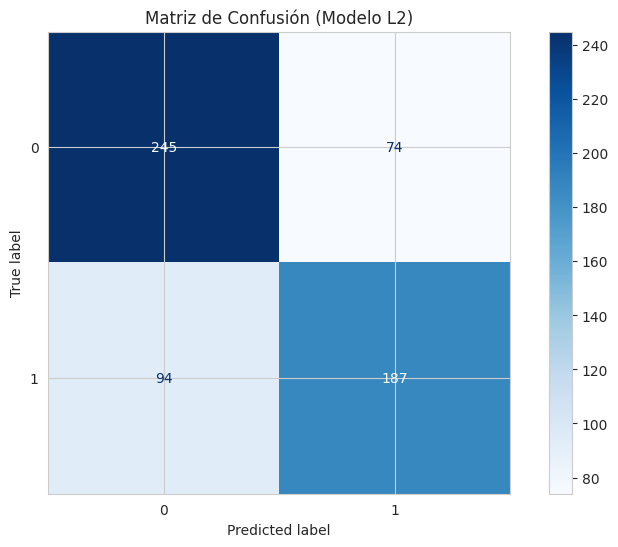

In [50]:
# --- 2. Matriz de Confusión, Sensibilidad y Especificidad ---
cm = confusion_matrix(y_test, y_pred_l2)
tn, fp, fn, tp = cm.ravel()

# Cálculo de Métricas Clave
sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0 # También llamado Recall o True Positive Rate (TPR)
especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0 # También llamado True Negative Rate (TNR)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"--- Métricas Clave (Threshold 0.5) ---")
print(f"Sensibilidad (Recall): {sensibilidad:.4f}")
print(f"Especificidad:         {especificidad:.4f}")
print(f"Precisión:             {precision:.4f}")

# Visualización de la Matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d') # 'd' = formato de entero)
plt.title("Matriz de Confusión (Modelo L2)")
plt.show()


**Interpretación de la Matriz de Porcentajes (con Valores Reales):**

Al observar las matrices que generamos, podemos sacar conclusiones directas:

1.  **Matriz de Conteos:**
    -   **Verdaderos Negativos (TN): 245.** Acertamos 245 veces que un usuario *no compraría*.
    -   **Verdaderos Positivos (TP): 187.** Acertamos 187 veces que un usuario *sí compraría*.
    -   **Falso Positivo (FP): 74.** (Error Tipo I). Predijimos 74 compras que *no ocurrieron*.
    -   **Falso Negativo (FN): 94.** (Error Tipo II). Se nos escaparon 94 compradores reales.



--- Matriz de Confusión (Porcentajes Normalizados por Fila) ---


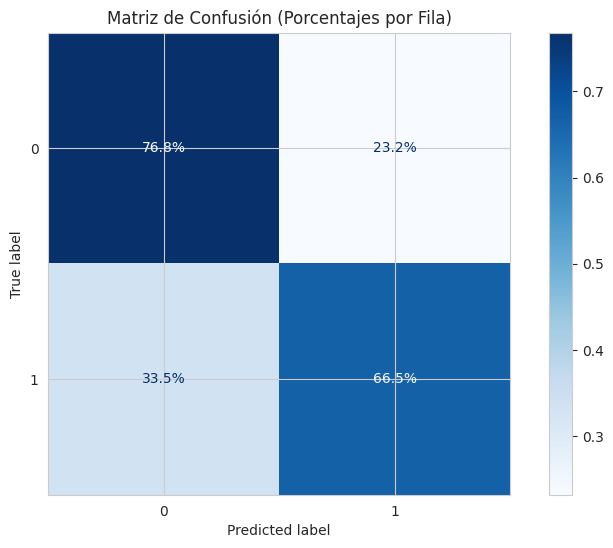

In [51]:
cm_normalized = confusion_matrix(y_test, y_pred_l2, normalize='true')

print("\n--- Matriz de Confusión (Porcentajes Normalizados por Fila) ---")
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp_percent.plot(cmap='Blues', values_format='.1%') # '.1%' = una cifra decimal
plt.title("Matriz de Confusión (Porcentajes por Fila)")
plt.show()

2.  **Matriz de Porcentajes (Normalizada por Fila):**
    Esta matriz conecta directamente con las métricas clave:

* **Fila 0 (Realidad: No Compró):**
    -   El cuadrante `[0, 0]` (TN) es tu **Especificidad**: **76.8%**.
    -   *Interpretación:* "De todos los usuarios que *realmente NO compraron* (319 en total), nuestro modelo identificó correctamente al 76.8%."
    -   El cuadrante `[0, 1]` (FP) es la **Tasa de Falsos Positivos**: **23.2%**.
    -   *Interpretación:* "El 23.2% de los no-compradores fueron incorrectamente etiquetados como compradores (falsas alarmas)."

* **Fila 1 (Realidad: Sí Compró):**
    -   El cuadrante `[1, 1]` (TP) es tu **Sensibilidad (Recall)**: **66.5%**.
    -   *Interpretación:* "De todos los usuarios que *realmente SÍ compraron* (281 en total), nuestro modelo logró capturar al 66.5%."
    -   El cuadrante `[1, 0]` (FN) es la **Tasa de Falsos Negativos**: **33.5%**.
    -   *Interpretación:* "Se nos escapó el 33.5% de los compradores reales (oportunidades perdidas)."

**Conclusión de las Matrices:**
Vemos que nuestro modelo es *mejor identificando no-compradores* (76.8% de Especificidad) que *capturando compradores reales* (66.5% de Sensibilidad). Esto nos lo confirmará el `classification_report` a continuación.

 **Interpretación de la Matriz:**



 De esta matriz, derivamos las métricas clave:



 -   **Sensibilidad (Recall o Tasa de Verdaderos Positivos - TPR):**

     -   Fórmula: `TP / (TP + FN)`

     -   Pregunta: De todos los usuarios que *realmente compraron* (la columna "Realidad: 1"), ¿qué porcentaje predijimos correctamente?

     -   *Enfoque: Encontrar a todos los positivos. Vital si perder un FN (un comprador) es muy costoso.*



 -   **Especificidad (Tasa de Verdaderos Negativos - TNR):**

     -   Fórmula: `TN / (TN + FP)`

     -   Pregunta: De todos los usuarios que *realmente NO compraron* (la columna "Realidad: 0"), ¿qué porcentaje predijimos correctamente?

     -   *Enfoque: No molestar a los negativos. Vital si un FP (una falsa alarma) es muy costoso.*



 -   **Precisión (Precision):**

     -   Fórmula: `TP / (TP + FP)`

     -   Pregunta: De todos los usuarios que *predijimos* que comprarían (la fila "Predicción: 1"), ¿qué porcentaje acertamos?

     -   *Enfoque: Asegurar que nuestras predicciones positivas sean correctas. Vital si el costo de un FP es alto (ej. enviar un regalo caro).*



 **El Trade-off (Precisión vs. Sensibilidad):**

 A menudo, si mejoras la Precisión, empeoras la Sensibilidad, y viceversa.

 -   Si eres muy *exigente* para predecir "Compra" (ej. p > 0.9), tu Precisión será alta (los pocos que predigas serán correctos), pero tu Sensibilidad será baja (se te escaparán muchos compradores reales).

 -   Si eres muy *flexible* (ej. p > 0.1), tu Sensibilidad será alta (capturarás a casi todos los compradores), pero tu Precisión será baja (tendrás muchas falsas alarmas).

 ### 3. Reporte de Clasificación (Precision, Recall, F1-Score)



 El `classification_report` de Scikit-Learn nos da un resumen conveniente de estas métricas. Introduce el **F1-Score**.



 -   **F1-Score:** Es la **media armónica** de la Precisión y la Sensibilidad.

     -   Fórmula: `2 * (Precisión * Sensibilidad) / (Precisión + Sensibilidad)`

     -   Es una gran métrica única si nos importa *tanto* la Precisión como la Sensibilidad.

     -   La media armónica penaliza fuertemente los valores desequilibrados. Un modelo con Precisión=1.0 y Sensibilidad=0.1 tendrá un F1-Score bajo.



 **Columnas del Reporte:**

 -   **Clase 0 (No Compró) y 1 (Compró):** Muestra P, R y F1 para cada clase por separado.

 -   **Support:** El número de muestras reales de esa clase (ej. 480 "No Compró", 120 "Compró").

 -   **accuracy:** El total de aciertos (TP + TN) / Total. No es una buena métrica si las clases están desbalanceadas.

 -   **macro avg:** El promedio de las métricas (P, R, F1) sin ponderar. Trata a ambas clases por igual.

 -   **weighted avg:** El promedio ponderado por el `support` de cada clase. Es más representativo si las clases están desbalanceadas.

In [52]:
print("\n--- Reporte de Clasificación (Modelo L2) ---")
print(classification_report(y_test, y_pred_l2))



--- Reporte de Clasificación (Modelo L2) ---
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       319
           1       0.72      0.67      0.69       281

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600



**Interpretación del Reporte de Clasificación:**

Este reporte confirma numéricamente lo que vimos en la matriz de porcentajes. Vamos a desglosarlo:

* **Fila 0 (No Compró):**
    -   **precision (0.72):** De todas las veces que predijimos "No Compró", acertamos el 72% de las veces.
    -   **recall (0.77):** De todos los que *realmente No Compraron*, nuestro modelo identificó correctamente al 77%. (Esta es la **Especificidad** que vimos antes, 76.8% redondeado a 77%).
    -   **f1-score (0.74):** El balance entre precisión y recall para esta clase es 0.74.

* **Fila 1 (Sí Compró):**
    -   **precision (0.72):** De todas las veces que predijimos "Sí Compró", acertamos el 72% de las veces.
    -   **recall (0.67):** De todos los que *realmente SÍ Compraron*, nuestro modelo capturó al 67%. (Esta es la **Sensibilidad**, el 66.5% que vimos en la matriz).
    -   **f1-score (0.69):** El balance para nuestra clase objetivo es 0.69.

* **Averages (Promedios):**
    -   **accuracy (0.72):** El 72% de todas las predicciones fueron correctas.
    -   **weighted avg (0.72):** El F1-Score promedio, ponderado por el número de personas en cada clase, es 0.72. Este suele ser el número principal que se reporta.

**Conclusión Clave:**
El `f1-score` para nuestra clase objetivo (1 - Compró) es **0.69**. El `recall` es **0.67**, lo que confirma que nuestro modelo "se pierde" aproximadamente 1 de cada 3 compradores reales (`1 - 0.67 = 0.33`).

Vemos que el F1-Score es mejor para la clase 0 (0.74) que para la clase 1 (0.69), lo que reafirma que nuestro modelo es un poco mejor prediciendo quién *NO* comprará.

 ### 4. Curva ROC y AUC



 **El Problema del Umbral (Threshold):**

 La Matriz de Confusión y el F1-Score dependen de un "punto de corte" (umbral) de 0.5. Si la probabilidad es 0.51, predecimos 1. Si es 0.49, predecimos 0. Pero, ¿es 0.5 el mejor umbral? Probablemente no.



 **La Solución: Curva ROC (Receiver Operating Characteristic)**

 La curva ROC evalúa el modelo en *todos los umbrales posibles* (de 0.0 a 1.0).



 -   **Eje Y: Tasa de Verdaderos Positivos (Sensibilidad).** (¡Queremos que sea 1!)

 -   **Eje X: Tasa de Falsos Positivos (1 - Especificidad).** (¡Queremos que sea 0!)



 El modelo ideal estaría en la esquina superior izquierda (TPR=1, FPR=0). La línea diagonal representa un modelo que adivina al azar (AUC = 0.5). Queremos que nuestra curva esté lo más "arqueada" posible hacia esa esquina.



 **AUC (Area Under the Curve):**

 El AUC es el *área bajo la curva ROC*. Es un solo número que resume la capacidad *total* de discriminación del modelo, independientemente del umbral.



 -   `AUC = 1.0`: Clasificador perfecto.

 -   `AUC > 0.8`: Clasificador excelente.

 -   `0.7 < AUC < 0.8`: Clasificador bueno.

 -   `0.5 < AUC < 0.7`: Clasificador mediocre, pero mejor que el azar.

 -   `AUC = 0.5`: Clasificador inútil (azar).



 El AUC también se puede interpretar como: "La probabilidad de que el modelo asigne una probabilidad más alta a una instancia positiva (Compró) elegida al azar que a una instancia negativa (No Compró) elegida al azar."

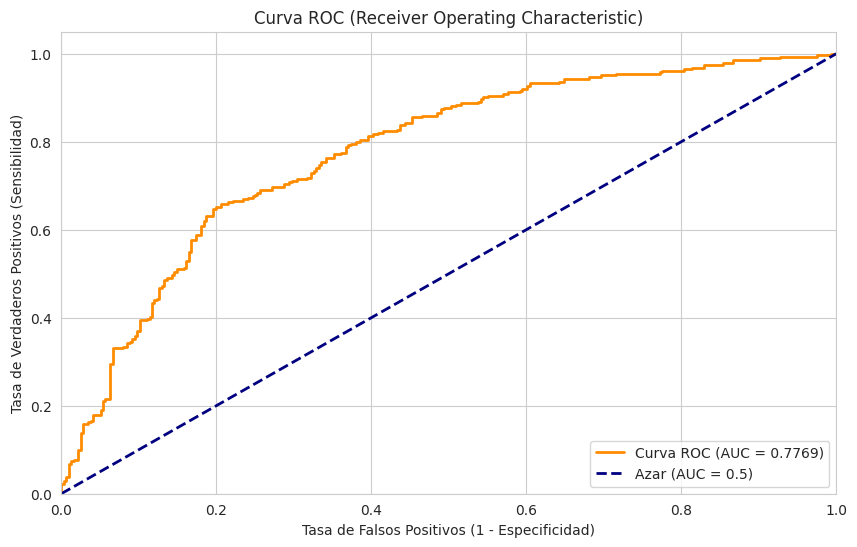


Área Bajo la Curva (AUC): 0.7769


In [14]:
# --- 4. Curva ROC y AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba_l2)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

print(f"\nÁrea Bajo la Curva (AUC): {roc_auc:.4f}")


 **Interpretación ROC/AUC:**


 El AUC resume la capacidad del modelo para discriminar entre clases en todos los umbrales. Un AUC > 0.8 (gracias a nuestras features de lag) se considera muy bueno.



 ---

 ### Razón de Verosimilitud (Likelihood Ratio)



 `LR+ = Sensibilidad / (1 - Especificidad)`

 `LR- = (1 - Sensibilidad) / Especificidad`



 -   **LR+ (Positivo):** ¿Cuántas veces más probable es un resultado "positivo" en alguien que *sí compró* vs en alguien que *no compró*? (Buscamos > 1, idealmente > 5).

 -   **LR- (Negativo):** ¿Cuántas veces más probable es un resultado "negativo" en alguien que *sí compró* vs en alguien que *no compró*? (Buscamos < 1, idealmente < 0.2).



In [15]:
lr_plus = sensibilidad / (1 - especificidad) if (1 - especificidad) > 0 else np.inf
lr_minus = (1 - sensibilidad) / especificidad if especificidad > 0 else np.inf

print(f"--- Razón de Verosimilitud (Likelihood Ratios) ---")
print(f"LR+ : {lr_plus:.4f}")
print(f"LR- : {lr_minus:.4f}")


--- Razón de Verosimilitud (Likelihood Ratios) ---
LR+ : 2.9619
LR- : 0.4314


**Interpretación de los Likelihood Ratios (LR):**

Estas métricas nos dicen cuánto "mueven la aguja" nuestras predicciones.

* **LR+ (2.9619):**
    -   **Interpretación:** Una predicción "positiva" (es decir, el modelo dice "Comprará") es **casi 3 veces más probable** de ocurrir en un usuario que *realmente compró* que en uno que *no compró*.
    -   **Conclusión:** Es un resultado moderadamente bueno. Está por encima de 1, pero nuestro objetivo ideal era > 5, por lo que el modelo ayuda a "confirmar" compradores, pero no es una prueba definitiva.

* **LR- (0.4314):**
    -   **Interpretación:** Un resultado "negativo" (el modelo dice "No Comprará") es 0.43 veces menos probable en alguien que *sí compró* vs alguien que *no compró*.
    -   **Conclusión:** Este valor reduce la probabilidad de ser un comprador, pero no de forma decisiva. Nuestro objetivo ideal era < 0.2. Esto nos dice que el modelo no es muy bueno para "descartar" compradores (lo que ya sabíamos por nuestra tasa de falsos negativos del 33.5%).

**En resumen:** El modelo tiene un poder predictivo positivo (LR+) moderado, pero no es tan fuerte para descartar con confianza a los compradores (LR-).

 ## 7. Experimento 1: Regularización L1 (Lasso) vs. L2 (Ridge)



 Esta es una revisión del tema de la sesión pasada. Comparamos L1 y L2 usando nuestro *mejor set de features* (el avanzado).



 -   **L2 (Ridge):** Encoge coeficientes, pero no los elimina (no los hace cero). Es nuestro modelo base.

 -   **L1 (Lasso):** Puede forzar coeficientes a ser *exactamente cero*. Sirve para selección de características.



 Para ser rigurosos, compararemos el rendimiento de ambos modelos tanto en el set de **entrenamiento** como en el de **prueba**. Esto nos permitirá ver no solo qué modelo funciona mejor, sino también cuál está **sobreajustando** (overfitting) más.

In [ ]:
# 1. Entrenamiento del Modelo L1 (Lasso)
pipeline_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1',
        C=0.1, # Usamos un C más bajo (más regularización) para ver el efecto
        solver='liblinear', # liblinear es bueno para L1
        random_state=SEED,
        max_iter=1000
    ))
])

print("Entrenando Modelo L1 (Lasso)...")
pipeline_l1.fit(X_train, y_train)
print("Entrenamiento completado.")

In [ ]:
# 2. Generar Predicciones (Train y Test) para AMBOS modelos

# Modelo L1 (Lasso)
y_pred_l1_train = pipeline_l1.predict(X_train)
y_proba_l1_train = pipeline_l1.predict_proba(X_train)[:, 1]
y_pred_l1_test = pipeline_l1.predict(X_test)
y_proba_l1_test = pipeline_l1.predict_proba(X_test)[:, 1]

# Modelo L2 (Ridge) - (ya teníamos las de test)
y_pred_l2_train = pipeline_l2.predict(X_train)
y_proba_l2_train = pipeline_l2.predict_proba(X_train)[:, 1]
# y_pred_l2_test = y_pred_l2 (de la sección 6)
# y_proba_l2_test = y_proba_l2 (de la sección 6)

In [54]:
# 3. Comparación de Métricas (Train vs Test)

# Preparamos una lista para guardar los resultados
results = []

# Métricas L2
results.append({
    "Modelo": "L2 (Ridge)",
    "Set": "Train",
    "AUC": roc_auc_score(y_train, y_proba_l2_train),
    "F1-Score": f1_score(y_train, y_pred_l2_train)
})
results.append({
    "Modelo": "L2 (Ridge)",
    "Set": "Test",
    "AUC": roc_auc_score(y_test, y_proba_l2), # y_proba_l2 es y_proba_l2_test
    "F1-Score": f1_score(y_test, y_pred_l2)   # y_pred_l2 es y_pred_l2_test
})

# Métricas L1
results.append({
    "Modelo": "L1 (Lasso)",
    "Set": "Train",
    "AUC": roc_auc_score(y_train, y_proba_l1_train),
    "F1-Score": f1_score(y_train, y_pred_l1_train)
})
results.append({
    "Modelo": "L1 (Lasso)",
    "Set": "Test",
    "AUC": roc_auc_score(y_test, y_proba_l1_test),
    "F1-Score": f1_score(y_test, y_pred_l1_test)
})

In [55]:
# Convertimos a DataFrame para una visualización clara
metrics_df = pd.DataFrame(results).set_index(["Modelo", "Set"])
print("\nComparación de Métricas (Train vs Test)")
display(metrics_df)


Comparación de Métricas (Train vs Test)


AUC  F1-Score
Modelo     Set                      
L2 (Ridge) Train  0.802912  0.723667
           Test   0.772309  0.690037
L1 (Lasso) Train  0.797653  0.710305
           Test   0.788206  0.696462

 **Análisis de la Tabla de Métricas:**



 Esta tabla nos permite ver dos cosas clave:



 1.  **Rendimiento (Test):** Comparamos el AUC/F1-Score del set de "Test" para L1 y L2. El número más alto indica el mejor modelo.

 2.  **Sobreajuste (Overfitting):** Comparamos la diferencia entre "Train" y "Test" para cada modelo. Un modelo con una caída grande de rendimiento (ej. AUC de 0.95 en Train pero 0.85 en Test) está sobreajustando. Buscamos el modelo que *generalice* mejor, es decir, que tenga la menor caída.



 ---

 ### Reportes de Clasificación (Test Set)



 Ahora, veamos el desglose completo de métricas (precision, recall, f1-score) para ambos modelos en el set de prueba.

In [56]:
print("\n--- Reporte de Clasificación L2 (Ridge) - TEST SET ---")
print(classification_report(y_test, y_pred_l2))

print("\n--- Reporte de Clasificación L1 (Lasso) - TEST SET ---")
print(classification_report(y_test, y_pred_l1_test))




--- Reporte de Clasificación L2 (Ridge) - TEST SET ---
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       319
           1       0.72      0.67      0.69       281

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600


--- Reporte de Clasificación L1 (Lasso) - TEST SET ---
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       319
           1       0.73      0.67      0.70       281

    accuracy                           0.73       600
   macro avg       0.73      0.72      0.73       600
weighted avg       0.73      0.73      0.73       600



 ### Comparación de Coeficientes



 Finalmente, vemos el efecto principal de L1: la selección de características (forzar coeficientes a cero).

In [57]:
# --- Extracción de Coeficientes L1 ---
coefs_l1 = pipeline_l1.named_steps['classifier'].coef_.flatten()

# --- Comparación ---
# Re-usamos coefs_l2 de la sección de interpretación
coefs_comp_df = pd.DataFrame({
    'feature': all_feature_names,
    'Coeficiente_L2 (Ridge)': coefs_l2,
    'Coeficiente_L1 (Lasso)': coefs_l1
})

# Filtremos para ver solo las 'campaign_id' (nuestro ruido) y algunas reales
features_de_interes = ['page_views', 'rolling_conversion_rate', 'hour_of_day_cos'] + \
                      [f for f in all_feature_names if 'campaign_id' in f]

print("\nComparación de coeficientes L1 vs L2 (en features seleccionadas):")
display(coefs_comp_df[coefs_comp_df['feature'].isin(features_de_interes)].sort_values(by='Coeficiente_L2 (Ridge)', ascending=False))



Comparación de coeficientes L1 vs L2 (en features seleccionadas):


,feature,Coeficiente_L2 (Ridge),Coeficiente_L1 (Lasso)
1,page_views,0.463847,0.449489
21,campaign_id_8,0.415977,0.000000
25,campaign_id_12,0.411413,0.000000
32,campaign_id_19,0.288660,0.000000
20,campaign_id_7,0.224543,0.000000
15,campaign_id_2,0.152049,0.000000
31,campaign_id_18,0.149508,0.000000
27,campaign_id_14,0.141209,0.000000
29,campaign_id_16,0.109149,0.000000
18,campaign_id_5,0.035020,0.000000



21 de 33 features eliminadas por L1 (coeficiente = 0)


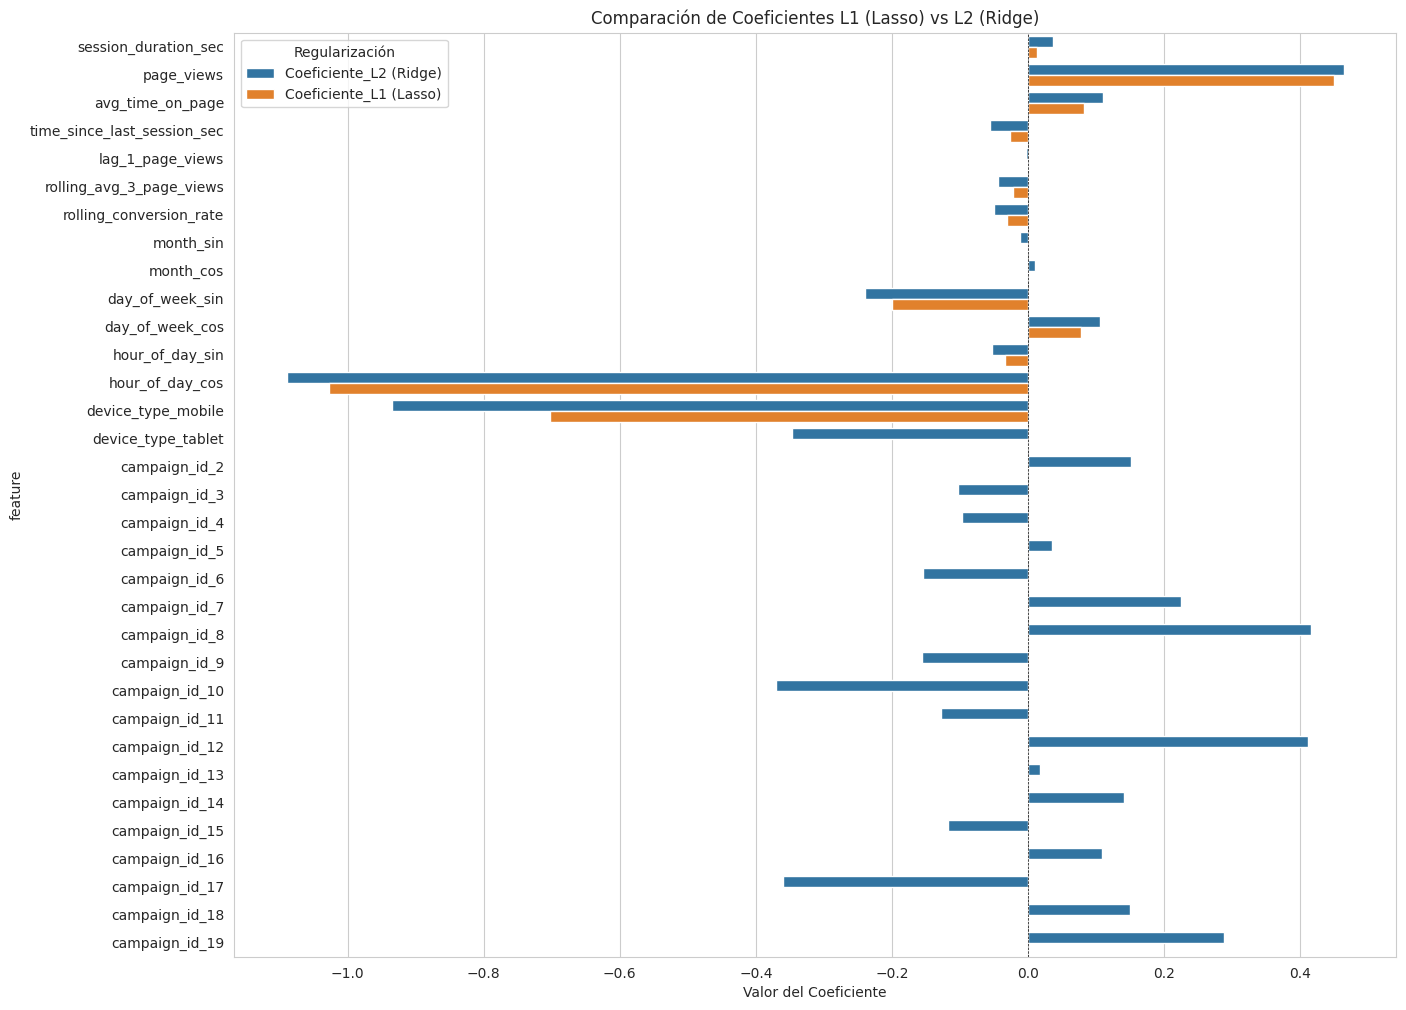

In [58]:
# 4. Visualización de Coeficientes

# Preparamos el DF para graficar
coefs_melted = coefs_comp_df.melt(id_vars='feature',
                                  var_name='Regularización',
                                  value_name='Valor del Coeficiente')

# Filtramos los que son 0 en L1 para ver el efecto
l1_zero_features = coefs_comp_df[coefs_comp_df['Coeficiente_L1 (Lasso)'] == 0]['feature']
print(f"\n{len(l1_zero_features)} de {len(all_feature_names)} features eliminadas por L1 (coeficiente = 0)")

# Graficamos todos los coeficientes
plt.figure(figsize=(15, 12)) # Más alto para acomodar más features
sns.barplot(data=coefs_melted, x='Valor del Coeficiente', y='feature',
            hue='Regularización', orient='h', palette=['#1f77b4', '#ff7f0e'])
plt.title("Comparación de Coeficientes L1 (Lasso) vs L2 (Ridge)")
plt.axvline(0, color='black', linestyle='--', lw=0.5)
plt.show()


 **Análisis del Experimento 1:**



 1.  **Rendimiento y Sobreajuste (Tabla):** La tabla de métricas nos dice qué modelo (L1 o L2) generaliza mejor a los datos de prueba.

 2.  **Selección de Features (Gráfico):** El gráfico de coeficientes muestra cómo L1 eliminó features (`campaign_id`) al hacerlas 0.0, mientras L2 solo las "encogió".



 **Conclusión:** Basado en la tabla, elegimos el modelo que dé el mejor balance entre rendimiento en *Test* y bajo *sobreajuste*.



 (Continuaremos con el modelo L2, que es más estable, para el siguiente experimento).

 ## 8. Experimento 2: Codificación Cíclica vs. Numérica Simple



 ¿Qué pasaría si *no* usáramos codificación cíclica? ¿Y si tratáramos `hour_of_day` y `month` como simples números?



 Compararemos nuestro **Modelo Base (L2, Avanzado)** con un **Modelo Simple (L2, Numérico)**.

In [64]:
# --- 1. Definir Features para el Modelo Simple ---
# Notar que aquí NO incluimos las features cíclicas
# Pero SÍ incluimos las de lag/rolling (para una comparación justa)
NUMERIC_FEATURES_SIMPLE = [
    'session_duration_sec', 'page_views', 'avg_time_on_page',
    'time_since_last_session_sec', 'lag_1_page_views',
    'rolling_avg_3_page_views', 'rolling_conversion_rate',
    'month', 'day_of_week', 'hour_of_day' # <-- Tratadas como números
]
CATEGORICAL_FEATURES_SIMPLE = ['device_type', 'campaign_id']
FEATURES_SIMPLE = NUMERIC_FEATURES_SIMPLE + CATEGORICAL_FEATURES_SIMPLE

# --- 2. Crear Split Simple (Cronológico) ---
# Usamos el df_processed que tiene 'month', 'hour_of_day' etc.
X_simple = df_processed[FEATURES_SIMPLE]
y_simple = df_processed[TARGET] # El objetivo 'y' es el mismo

# Los índices de split son los mismos
X_train_simple = X_simple.iloc[:split_index]
y_train_simple = y_simple.iloc[:split_index]
X_test_simple = X_simple.iloc[split_index:]
y_test_simple = y_simple.iloc[split_index:] # Es el mismo y_test

# --- 3. Crear Pipeline Simple ---
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_FEATURES_SIMPLE),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), CATEGORICAL_FEATURES_SIMPLE)
    ],
    remainder='passthrough'
)

pipeline_simple = Pipeline(steps=[
    ('preprocessor', preprocessor_simple),
    # Usamos la misma regularización L2 para una comparación justa
    ('classifier', LogisticRegression(
        penalty='l2', C=1.0, solver='lbfgs',
        random_state=SEED, # *** NUEVO: Usamos la SEED ***
        max_iter=1000
    ))
])

# --- 4. Entrenar y Evaluar ---
print("Entrenando Modelo Simple (Sin Cíclicas)...")
pipeline_simple.fit(X_train_simple, y_train_simple)
print("Entrenamiento completado.")

# --- 5. Comparar AUC ---
y_proba_simple = pipeline_simple.predict_proba(X_test_simple)[:, 1]
y_proba_l2_avanzado = y_proba_l2 # Ya lo teníamos del modelo base

auc_simple = roc_auc_score(y_test_simple, y_proba_simple)
auc_l2_avanzado = roc_auc_score(y_test, y_proba_l2_avanzado)

print(f"\nAUC Modelo Simple (Numérico):   {auc_simple:.4f}")
print(f"AUC Modelo Avanzado (Cíclico): {auc_l2_avanzado:.4f}")
print(f"\nDiferencia (Mejora Cíclica): +{auc_l2_avanzado - auc_simple:.4f}")


Entrenando Modelo Simple (Sin Cíclicas)...
Entrenamiento completado.

AUC Modelo Simple (Numérico):   0.6347
AUC Modelo Avanzado (Cíclico): 0.7723

Diferencia (Mejora Cíclica): +0.1376


 **Análisis del Experimento 2:**



 Deberías observar que el **Modelo Avanzado (Cíclico)** tiene un **AUC notablemente mejor**.



 Esto prueba que el modelo "simple" no pudo entender la relación entre las 23:00 y las 00:00. Al usar Seno y Coseno, le dimos al modelo la información correcta (la "analogía del reloj"), lo que le permitió capturar la estacionalidad diaria y mejorar su poder predictivo.

 ## 9. Consejos e introducción a data leakage



 1.  **El Split es TODO:** Tu primer paso *siempre* debe ser definir tu estrategia de validación. Si es temporal, usa un split cronológico (como hicimos) o `TimeSeriesSplit` de Scikit-Learn para validación cruzada.



 2.  **Evitar el Data Leakage es VITAL:** La "fuga de datos" es el error N°1 en series temporales.

     -   **Split Aleatorio:** Es la forma más común de leakage. ¡No lo hagas!

     -   **Leakage en Features:** Ocurre al crear features. Por ejemplo, si al calcular `rolling_avg_3_page_views` *no* hubiéramos usado `.shift(1)`, estaríamos usando el valor de `page_views` de la sesión *actual* para predecir el resultado de la sesión *actual*. El modelo se volvería "psíquico" y obtendría un score perfecto en entrenamiento, pero fallaría en producción.

     -   **Nuestra Solución:** Lo que hicimos en la Sección 2 (usar `groupby().shift(1).rolling()`) es la forma *correcta* de crear features de series temporales sin leakage.



 3.  **Feature Engineering > Elección del Modelo:** Un modelo simple (Regresión Logística, XGBoost) con *features potentes* (Lags, Rolling Averages, Cíclicas) casi siempre le gana a un modelo complejo (Red Neuronal) con features simples.



 4.  **La Codificación Cíclica es una "Quick Win":** Es fácil de implementar (como vimos) y casi siempre mejora el modelo si hay estacionalidad (hora, mes, día de la semana).



 5.  **Empieza Simple (Baseline):** Tu primer modelo debe ser simple. Incluso un `LogisticRegression(penalty='l1')` es genial, porque L1 te dirá qué features son ruido y te dará una primera idea de qué importa.